Import the needed packages and ml modules 

In [1]:
import numpy as np
import pandas as pd

import xarray as xr
import os
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import folium
import folium.plugins
import pandas as pd
import xarray as xr
import branca
import branca.colormap as cm

Read events and filter amd split them into 80:20

In [2]:
#Read event list from file
event_list = np.loadtxt('../data/events/sample_events1212.txt', dtype='str')

#filter events with lower than threshold of 0.1 at atleast one station
offshore_threshold = 0.1
onshore_threshold = 0.25

allpts_max = np.loadtxt('../data/info/grid0_allpts87_alleve1212.offshore.txt', dtype='str',skiprows=1)
regions = ['CT','SR']

GaugeNo_CT = list(range(35,44)) #for Catania
GaugeNo_SR = list(range(53,58)) #for Siracusa
All_Gauges = GaugeNo_SR #+ GaugeNo_CT 

inun_info = np.loadtxt('../data/info/CDepth_SR_alleve1212.onshore.txt', dtype='str',skiprows=1)
Inun_Max = inun_info[:,2]

Gauge_Max = allpts_max[:,All_Gauges]
maxPerEve = Gauge_Max.astype(float).max(axis=1)

#filter events greater than thresholds for gauge and min inundation depth
offshore_check = maxPerEve>offshore_threshold
onshore_check = Inun_Max.astype(float)>onshore_threshold
overall_check = offshore_check & onshore_check
event_list = event_list[overall_check]

#set seed
np.random.seed(123)

#shuffle events
np.random.shuffle(event_list)

#split events in train and test and validation as 65:35
train_events = event_list[:int(len(event_list)*0.65)] 
test_events = event_list[int(len(event_list)*0.65):]

print(len(train_events), len(test_events))

#save events in file
np.savetxt('../data/events/shuffled_events.txt', event_list, fmt='%s')
np.savetxt('../data/events/train_events.txt', train_events, fmt='%s')
np.savetxt('../data/events/test_events.txt', test_events, fmt='%s')


767 413


In [4]:
#files
sim_dir = '../data/simu/PS_manning003/'
Dpath_format = sim_dir + '/{:s}/{:s}_flowdepth.nc'
Zpath_format = sim_dir + '/{:s}/{:s}_defbathy.nc'
TSpath_format = sim_dir + '/{:s}/grid0_ts.nc'

reg = regions[1]
eve = event_list[1]
print(reg, eve)

D_grids = xr.open_dataset(Dpath_format.format(eve,reg)) #grid file of depth
Z_grids = xr.open_dataset(Zpath_format.format(eve,reg)) #grid file of bathymetry
TS_pts = xr.open_dataset(TSpath_format.format(eve)) #pts file of time series

#TODO: should you remove the deformation from both inundation height and offshore time series eta when starting to use events nearshore and causing bigger deformation?

# t=TS_pts.eta
# t_SR = t[:,GaugeNo_SR] #5 (pts) x 481 (ts) x no of events 

# z = Z_grids.z #land mask

# h = H_grids.max_height
# h_SR = h.where(z.values > 0) # 948(y) x 1300(x) x no of events

# sys.getsizeof(t_SR)


SR E02020N3739E02658N3366-PS-Mur_PYes_Var-M888_E02434N3452_S004


Read the netcdf files for offshore and onshore data and prepare training, validation and test batch

In [28]:
# d_array = np.zeros((len(event_list), 948, 1300))  # 948(y) x 1300(x) x no of events
# t_array = np.zeros((len(event_list), 480, 5))  # 480(ts) x 5(pts) x no of events

# for i,eve in enumerate(event_list):
#     print('processing',i,'of',len(event_list),eve,end='\r')
#     D_grids = xr.open_dataset(Dpath_format.format(eve,reg)) #grid file of depth
#     Z_grids = xr.open_dataset(Zpath_format.format(eve,reg)) #grid file of bathymetry
#     TS_pts = xr.open_dataset(TSpath_format.format(eve)) #pts file of time series
#     t=TS_pts.eta
#     t_SR = t[1:,GaugeNo_SR] #5 channels of 480 timesetps x no of events 
#     z = Z_grids.z #land mask
#     d = D_grids.z
#     d_SR = d.where(z.values > 0) # 948(y) x 1300(x) x no of events
    
#     d_SR = d_SR.values
#     t_SR = t_SR.values

#     d_SR[np.isnan(d_SR)] = 0
#     t_SR[np.isnan(t_SR)] = 0

#     #update to the empty array
#     d_array[i,:,:] = d_SR
#     t_array[i,:,:] = t_SR

# #arrange dimensions to be (no of events, 5 channels, 480 time steps)
# t_array = np.transpose(t_array, (0,2,1))



try normalisation and std of data, not sure how it impacts the extrapolation ability of model

In [29]:
# # #normalize the data to 0-1 for h
# # np.savetxt('../data/processed/h_SR_normpara.txt',
# #            np.hstack((h_array.min(),h_array.max()))) 
# # h_array = (h_array - h_array.min())/(h_array.max() - h_array.min())    

# # #standardize t
# # np.savetxt('../data/processed/t_SR_stdpara.txt',
# #            np.hstack((t_array.mean(),t_array.std())))
# # t_array = (t_array - t_array.mean())/t_array.std()

# #save the data
# np.save('../data/processed/d_SR.npy', d_array)
# np.save('../data/processed/t_SR.npy', t_array)

In [30]:
# #save an numpy binary
# onshore_map = np.memmap('../data/processed/d_SR.dat',
#                          mode='w+',
#                          dtype=float,
#                          shape=(d_array.shape[0], d_array.shape[1], d_array.shape[2]))
# onshore_map[:] = d_array[:]

# offshore_map = np.memmap('../data/processed/t_SR.dat',
#                          mode='w+',
#                          dtype=float,
#                          shape=(t_array.shape[0], t_array.shape[1], t_array.shape[2]))
# offshore_map[:] = t_array[:]


Quick check of a data sample

7.142872333526611


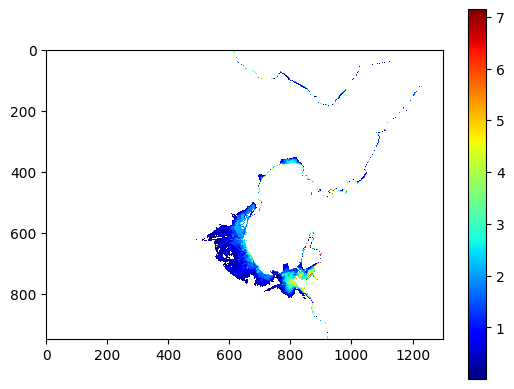

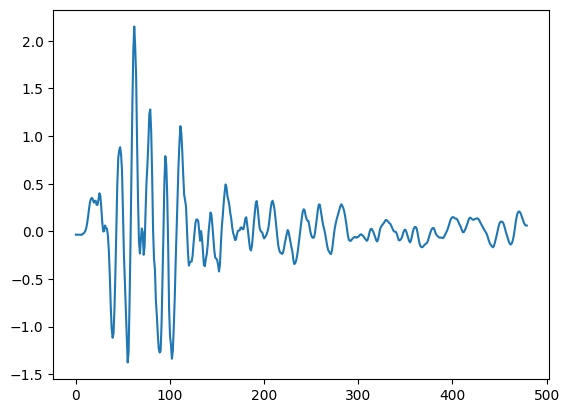

In [31]:
# d_array  = np.load('../data/processed/d_SR.npy')
# t_array  = np.load('../data/processed/t_SR.npy')

d_array = np.memmap('../data/processed/d_SR.dat',
                mode='r+',
                dtype=float,
                shape=(1180, 948, 1300))

t_array = np.memmap('../data/processed/t_SR.dat',
                mode='r+',
                dtype=float,
                shape=(1180, 5, 480))

red_d_array = np.memmap('../data/processed/dflat_SR.dat',
                         mode='r+',
                         dtype=float,
                         shape=(1180, 75476))

data = d_array[492,:,:]
data = np.ma.masked_where(data == 0, data)
print(data.max())
plt.imshow(data, cmap='jet',interpolation='none')
plt.colorbar()
plt.show()

data_t = t_array[492,0,:]
plt.plot(data_t)
plt.show()


In [32]:
#find elements which are always zero across all the events
# zero_indices = np.where(np.all(d_array == 0, axis=0))
# zero_mask = np.all(d_array == 0, axis=0)

#savemask
# np.save('../data/processed/SR_zero_mask.npy', zero_mask)

# red_d_array = d_array[:, ~zero_mask]
# print(red_d_array.shape)

# print(np.count_nonzero(red_d_array[865,:])
#        + len(np.where(red_d_array[865,:]==0)[0]))


In [33]:
np.random.seed(0)
torch.random.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Autoencoder model for onshore time series

In [173]:
class Autoencoder(nn.Module):
    def __init__(self,xy, zlist = [32,64,128]):
        super(Autoencoder, self).__init__()
        # more channels mean more fine details, more resolution 
        # less channel and layers less likely to overfit so better maximas and minimas
        # more accuracy but slower and more memory and data needed to train
        self.xy = xy
        
        # define encoder layers
        if len(zlist) == 1:
            self.encoder = nn.Sequential(          
                nn.Linear(xy, zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
            self.decoder = nn.Sequential(
                nn.Linear(zlist[0], xy),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
        elif len(zlist) == 2:
            self.encoder = nn.Sequential(          
                nn.Linear(xy, zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], zlist[1]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
            self.decoder = nn.Sequential(
                nn.Linear(zlist[1], zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], xy),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
        elif len(zlist) == 3:
            self.encoder = nn.Sequential(          
                nn.Linear(xy, zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], zlist[1]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[1], zlist[2]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
            self.decoder = nn.Sequential(
                nn.Linear(zlist[2], zlist[1]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[1], zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], xy),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )

    def encode(self, x):
        # x = x.view(x.size(0), -1) # flatten the input
        x = self.encoder(x)
        # print(x.shape)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        # x = x.view(x.size(0), self.y, -1) # unflatten the output
        # print(x.shape)
        return x
    
    def forward(self, x):
        x = self.encode(x)  
        x = self.decode(x)
        return x

def trainAE(num_folds,batch_size,nepochs,lr,xy,zlist):
    print('Training Autoencoder:',zlist)
    # Loop over folds
    if num_folds > 1:
        # Define k-fold indices
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        splits = kf.split(data)
        fold_losses = [] 
        for idx, (train_idx, val_idx) in enumerate(splits):
            t_epoch_losses = []
            es_epoch_losses = []
            # Split data into train and validation sets
            x_train, x_val = data[train_idx], data[val_idx]

            # Create PyTorch DataLoader objects
            train_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train))
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            val_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_val))
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Initialize model, optimizer, and loss function
            model = Autoencoder(xy,zlist)
            model.to('cuda')
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Train model
            for epoch in range(nepochs):
                train_loss = 0
                es_losses = 0
                for batch_idx, (batch_data,) in enumerate(train_loader):
                    optimizer.zero_grad()
                    batch_data = batch_data.to('cuda')
                    recon_data = model(batch_data)
                    loss = criterion(recon_data, batch_data)
                    train_loss += loss.item()
                    loss.backward()
                    optimizer.step()
                
                for batch_idx, (batch_data,) in enumerate(val_loader):
                    batch_data = batch_data.to('cuda')
                    recon_data = model(batch_data)
                    vloss = criterion(recon_data, batch_data)
                    es_losses += vloss.item()

                print(f"Fold {idx + 1},epoch:{epoch},training loss: {train_loss / len(train_loader):.5f},\
                      val loss: {es_losses / len(val_loader):.5f}", end="\r")
                
                t_epoch_losses.append(train_loss / len(train_loader))
                es_epoch_losses.append(es_losses / len(val_loader))
            
            #plot training/val loss
            plt.plot(t_epoch_losses, color='blue')
            plt.plot(es_epoch_losses, color='red')
            plt.title(f"Training loss for fold {idx + 1}")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.yscale('log')
            plt.savefig(f"./../model/plot/onshore_fold{idx + 1}_loss_z_{zlist}.png")   
            plt.clf()

            print(f"Fold {idx + 1},epoch:{epoch},training loss: {train_loss / len(train_loader):.5f}")    
            
            # Validation model
            model.eval()
            with torch.no_grad():
                val_loss = 0
                for batch_idx, (batch_data,) in enumerate(val_loader):
                    batch_data = batch_data.to('cuda')
                    recon_data = model(batch_data)
                    loss = criterion(recon_data, batch_data)
                    val_loss += loss.item()
            print(f"Fold {idx + 1}, validation loss: {val_loss / len(val_loader):.5f}")
            #save fold loss
            fold_losses.append(val_loss / len(val_loader))
            
        #average validation loss accross folds
        print(f"Average validation loss: {np.mean(fold_losses):.5f} for zdim = {zlist}")
    
    elif num_folds == 0:
    
        # Create PyTorch DataLoader objects
        train_dataset = torch.utils.data.TensorDataset(torch.Tensor(data[0:int(len(data)*0.99)]))   
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_dataset = torch.utils.data.TensorDataset(torch.Tensor(data[int(len(data)*0.99):]))
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_data))
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, optimizer, and loss function
        model = Autoencoder(xy,zlist)
        model.to('cuda')
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        t_epoch_losses = []
        es_epoch_losses = []
        test_epoch_losses = []

        # Train model
        for epoch in range(nepochs):
            train_loss = 0
            es_losses = 0
            test_losses = 0
            for batch_idx, (batch_data,) in enumerate(train_loader):
                optimizer.zero_grad()
                batch_data = batch_data.to('cuda')
                recon_data = model(batch_data)
                loss = criterion(recon_data, batch_data)
                train_loss += loss.item()
                loss.backward()
                optimizer.step()

            #save model at every 200th epoch after 1000th epoch
            if epoch > 1000 and epoch % 200 == 0:
                torch.save(model, f"./../model/out/model_onshore_zdim_{zlist}_epoch_{epoch}.pt")

            for batch_idx, (batch_data,) in enumerate(val_loader):
                batch_data = batch_data.to('cuda')
                recon_data = model(batch_data)
                vloss = criterion(recon_data, batch_data)
                es_losses += vloss.item()
            
            for batch_idx, (batch_data,) in enumerate(test_loader):
                batch_data = batch_data.to('cuda')
                recon_data = model(batch_data)
                tloss = criterion(recon_data, batch_data)
                test_losses += tloss.item()
            
            print(f"NoFold,epoch:{epoch},training loss: {train_loss / len(train_loader):.5f},val loss: {es_losses / len(val_loader):.5f},test loss: {test_losses / len(test_loader):.5f}", end="\r")
    
            t_epoch_losses.append(train_loss / len(train_loader))
            es_epoch_losses.append(es_losses / len(val_loader))
            test_epoch_losses.append(test_losses / len(test_loader))
            
            #save model at every 200th epoch after 1000th epoch
            if epoch % 100 == 0:
                plt.plot(t_epoch_losses, color='blue')
                plt.plot(es_epoch_losses, color='red')
                plt.plot(test_epoch_losses, color='green')
                plt.title(f"Training loss for Nofold")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.yscale('log')
                plt.savefig(f"./../model/plot/onshore_Nofold_loss_z_{zlist}.png")   
                # plt.clf()

        # Validation model
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch_idx, (batch_data,) in enumerate(val_loader):
                batch_data = batch_data.to('cuda')
                recon_data = model(batch_data)
                loss = criterion(recon_data, batch_data)
                val_loss += loss.item()
        print(f"NoFold, validation loss: {val_loss / len(val_loader):.5f}")

        # # Test model for final evaluation
        # predic = np.zeros(test_data.shape)
                        
        # Test model
        with torch.no_grad():
            test_loss = 0
            for batch_idx, (batch_data,) in enumerate(test_loader):
                batch_data = batch_data.to('cuda')
                recon_data = model(batch_data)
                loss = criterion(recon_data, batch_data)
                test_loss += loss.item()
                # predic[batch_idx*batch_size:(batch_idx+1)*batch_size] = recon_data.cpu().numpy()
            print(f"test loss: {test_loss / len(test_loader):.5f}")

    #save model final
    torch.save(model, f"./../model/out/model_onshore_zdim_{zlist}_epoch_{epoch}.pt")
    
    #append z info + train,val,test loss to file as new line
    with open(f"./../model/out/model_onshore_zdim_loss.txt", "a") as text_file:
        text_file.write(f"zlist: {zlist}, train loss: {t_epoch_losses[-1]}, val loss: {es_epoch_losses[-1]}, test loss: {test_loss / len(test_loader):.5f}\n")
    text_file.close()   


Training Autoencoder: [64, 64]
NoFold, validation loss: 0.00570 0.00303,val loss: 0.00570,test loss: 0.00816
test loss: 0.00816


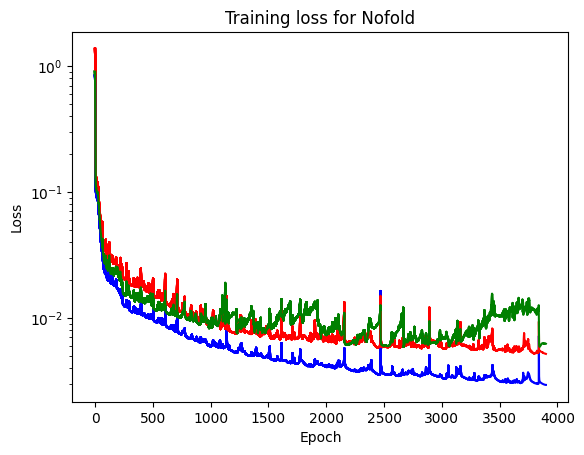

In [174]:
# input data
data = red_d_array[:int(len(red_d_array)*0.65),:]
test_data = red_d_array[int(len(red_d_array)*0.65):,:]

# y = data.shape[1] 
# x = data.shape[2]

xy= data.shape[1]
batch_size = 20
num_epochs = 4000
learning_rate = 0.0001
num_folds = 0

test_zlist = [[64,64]]

for zlist in test_zlist:
    #train model and save loss info to file
    trainAE(num_folds,batch_size,num_epochs,learning_rate,xy,zlist)


In [178]:
model = torch.load(f"./../model/out/model_onshore_zdim_[64, 64]_epoch_2200.pt")
#read model from file for testing

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]       4,830,528
         LeakyReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
         LeakyReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           4,160
         LeakyReLU-6                   [-1, 64]               0
            Linear-7                [-1, 75476]       4,905,940
         LeakyReLU-8                [-1, 75476]               0
Total params: 9,744,788
Trainable params: 9,744,788
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.29
Forward/backward pass size (MB): 1.15
Params size (MB): 37.17
Estimated Total Size (MB): 38.62
----------------------------------------------------------------
test loss: 0.00620


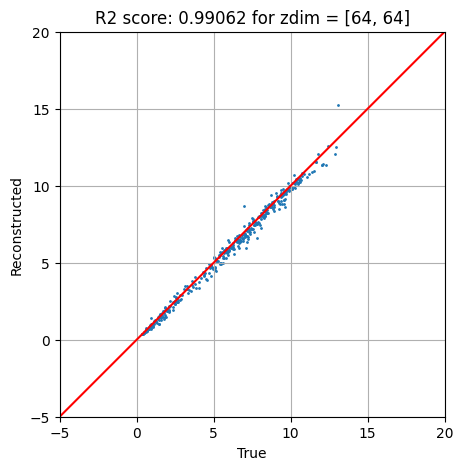

In [179]:

summary(model,(xy,))
model.eval()
# Test model for final evaluation
predic = np.zeros(test_data.shape)
criterion = nn.MSELoss()                
# Test model
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_data))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    test_loss = 0
    for batch_idx, (batch_data,) in enumerate(test_loader):
        batch_data = batch_data.to('cuda')
        recon_data = model(batch_data)
        loss = criterion(recon_data, batch_data)
        test_loss += loss.item()
        predic[batch_idx*batch_size:(batch_idx+1)*batch_size] = recon_data.cpu().numpy()
    print(f"test loss: {test_loss / len(test_loader):.5f}")

# Plot results max height for all events
test_max = np.max(test_data,axis=(1))
recon_max = np.max(predic,axis=(1))

plt.figure(figsize=(5, 5))
plt.scatter(test_max, recon_max, s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.title(f"R2 score: {r2_score(test_max, recon_max):.5f} for zdim = {zlist}")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5, 20)
plt.ylim(-5, 20)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.savefig(f"./../model/plot/onshore_test_z_{zlist}.png")   
plt.show()

-0.059180788695812225


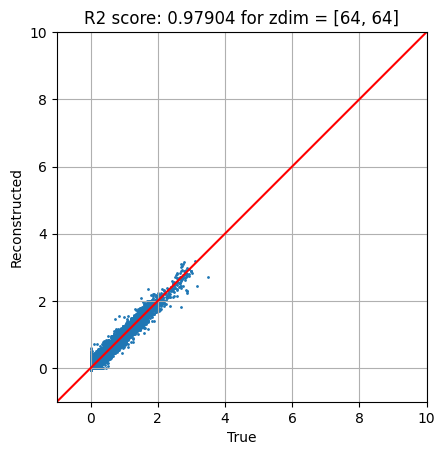

E02020N3739E02658N3366-PS-Str_PYes_Var-M861_E02105N3701_S002



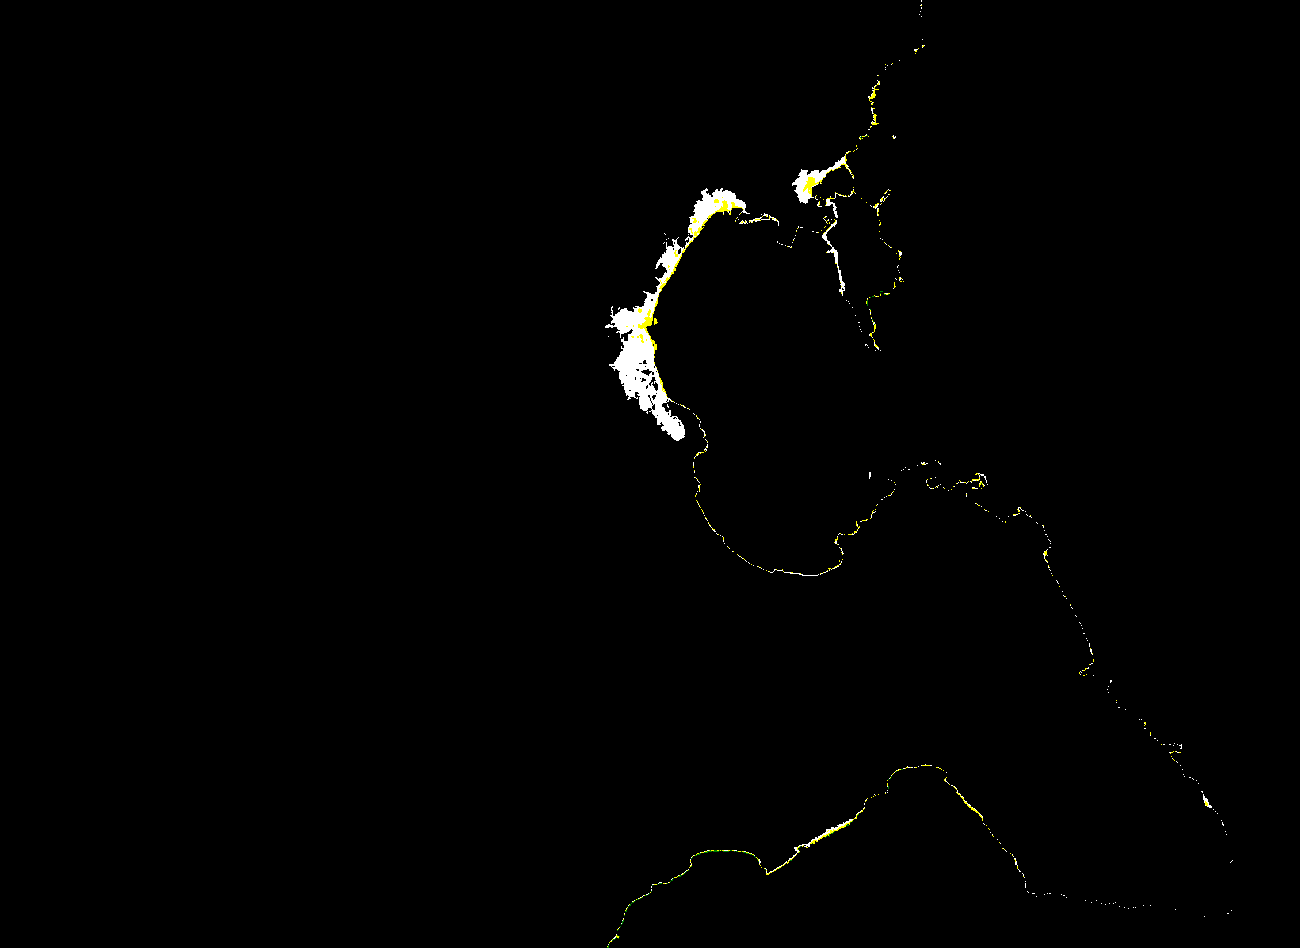
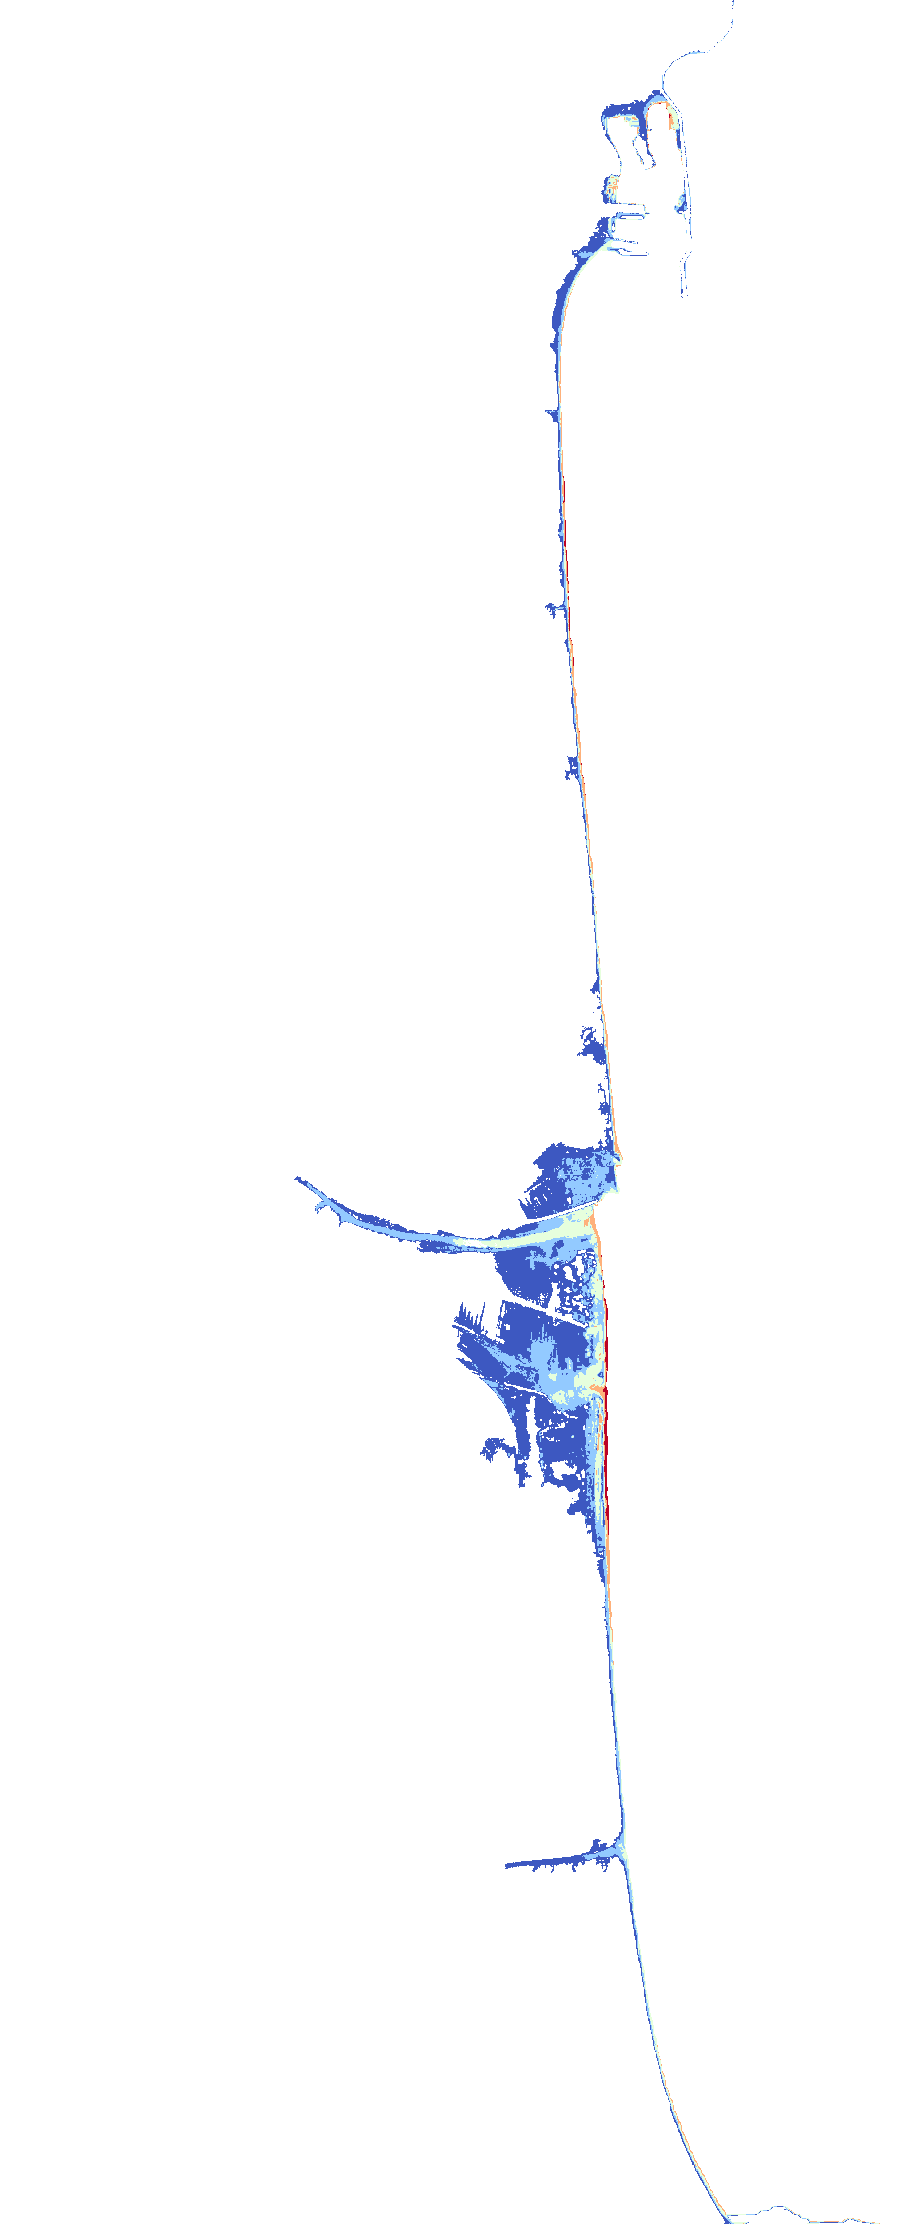
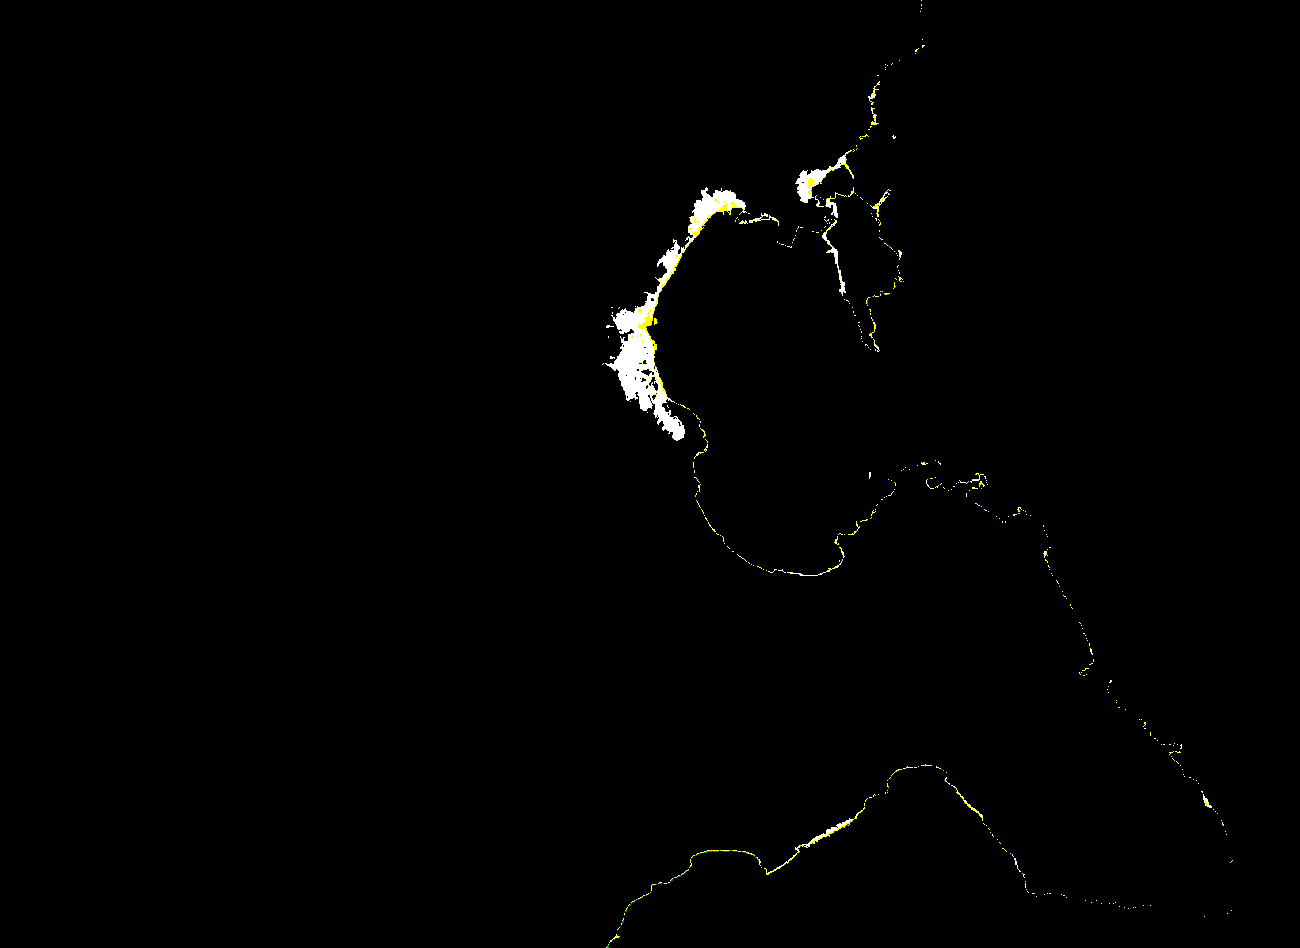
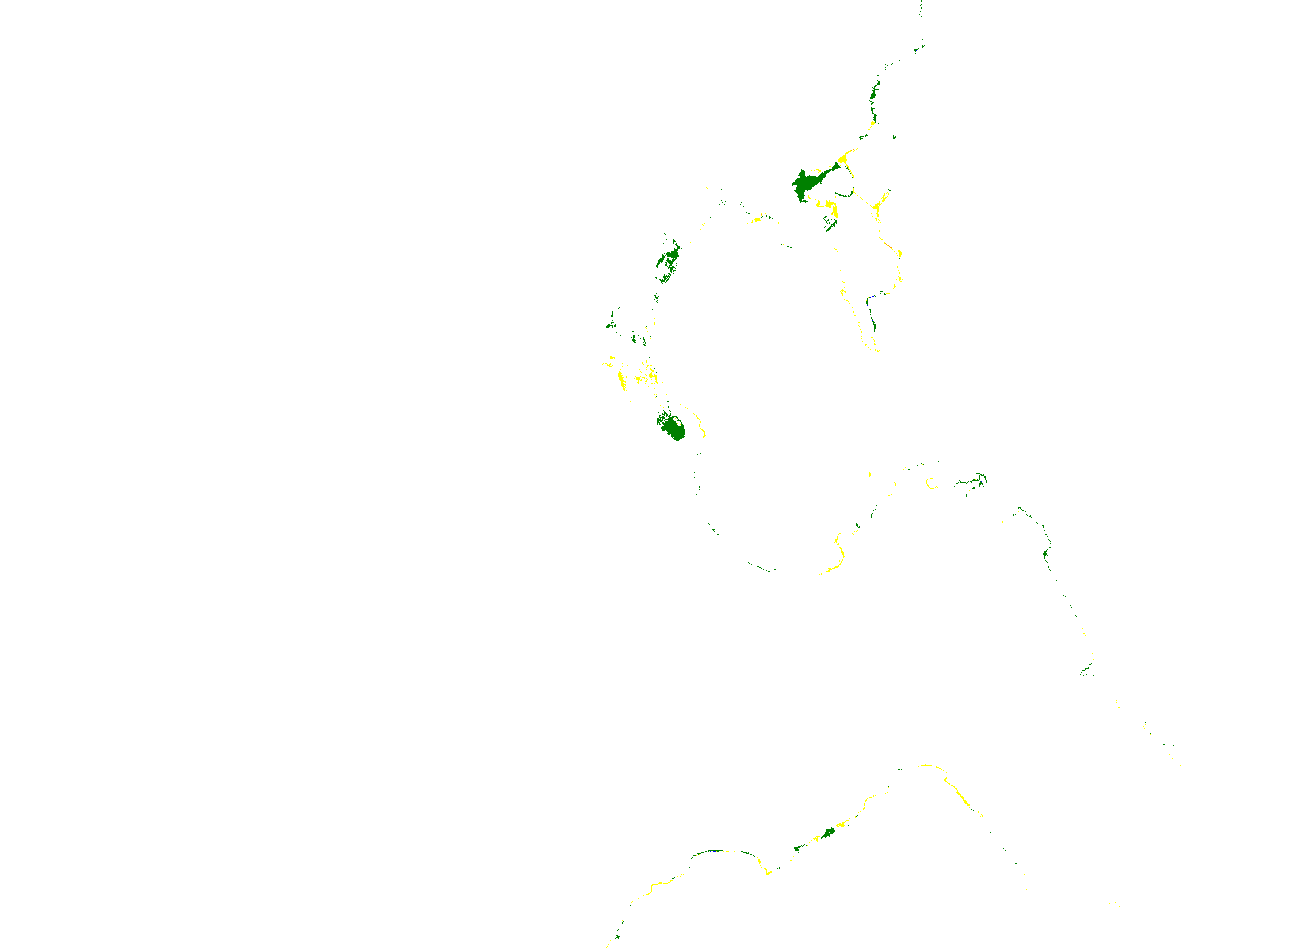

In [181]:
eve_no = 222
# Plot results max depth and error for one event with basemap around sicily

#grid map
error2fill = np.zeros(d_array.shape[1:])
depth2fill = np.zeros(d_array.shape[1:])

print(min(predic[eve_no,:]))

zero_mask = np.load('../data/processed/SR_zero_mask.npy')
error2fill[~zero_mask] = test_data[eve_no, :] - predic[eve_no, :]
depth2fill[~zero_mask] = predic[eve_no,:]

plt.scatter(test_data[eve_no,:], predic[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(test_data[eve_no,:], predic[eve_no,:]):.5f} for zdim = {zlist}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

all_ids = np.loadtxt('../data/events/shuffled_events.txt', dtype='str',skiprows=0)
test_ids = all_ids[int(len(all_ids)*0.65):]
eve_info = pd.read_csv('../data/info/about_alleve1212_PS.txt', sep='\t')
eve = test_ids[eve_no]

sim_dir = '../data/simu/PS_manning003/'
# Load the points file
data_pts = np.loadtxt('../resources/raw/pois_eastern_sicily_2km.txt', dtype=str)
id_pts = data_pts[:, 0]
lon_pts = data_pts[:, 1].astype(float)
lat_pts = data_pts[:, 2].astype(float)
z_pts = data_pts[:, 3].astype(float)

ds_ts = xr.open_dataset(os.path.join(sim_dir,eve,'grid0_ts.nc')) #gridts file
ds_grids_CT = xr.open_dataset(os.path.join(sim_dir,eve,'CT_flowdepth.nc')) #gridts file
ds_grids_SR = xr.open_dataset(os.path.join(sim_dir,eve,'SR_flowdepth.nc')) #gridts file

# Create a Folium map centered on the data's extent
m = folium.Map(location=[np.mean(lat_pts),np.mean(lon_pts)], zoom_start=10)
m = folium.Map(location=[37,15.3], zoom_start=12)
# Basemaps
folium.TileLayer(tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True,
        show = False).add_to(m)

# Create a feature group for the offshore points 
fg_pts = folium.FeatureGroup(name='Offshore Points Txt').add_to(m)
# fg_ptsNC = folium.FeatureGroup(name='Offshore Points NetCDF').add_to(m)
fg_gridnc_SR = folium.FeatureGroup(name='SR Grid NetCDF').add_to(m)
fg_gridnc_CT = folium.FeatureGroup(name='CT Grid NetCDF').add_to(m)
fg_gridnc_ML_d = folium.FeatureGroup(name='ML Grid Depth NetCDF').add_to(m)
fg_gridnc_ML_e = folium.FeatureGroup(name='ML Grid Error NetCDF').add_to(m)

#add eq lat lon point
print(eve)

# E01548N3896E01854N3659-PS-Str_PYes_Hom-M861_E01673N3781_S005
lon = float(str(eve).split('_')[-2][1:5])/10
lat = float(str(eve).split('_')[-2][7:11])/100

folium.CircleMarker(location=[lat,lon],radius = 15,color='red',fill_color = 'red').add_to(m)

# Add a marker for each point with a tooltip showing its id
for id, lat, lon,z in zip(id_pts, lat_pts, lon_pts, z_pts):
    info = f"ID:{id}, Depth: {z} "  # Create tooltip string
    folium.Marker(location=[lat, lon],
                  tooltip=info,
                  icon=folium.Icon(color='blue', icon='')).add_to(fg_pts)

df_ts = pd.DataFrame({'lat':ds_ts.latitude.values.astype(float),
                      'lon':ds_ts.longitude.values.astype(float),
                      'z':ds_ts.deformed_bathy.values.astype(float)})

# for i,row in df_ts.iterrows():
#     info = f"ID:{i}, Depth: {row['z']} "  # Create tooltip string
#     folium.Marker(location=[row['lat'], row['lon']],
#                   tooltip=info,
#                  icon=folium.Icon(color='red', icon='')).add_to(fg_ptsNC)

# Add grid netcdfs  
# #CATANIA  
data2plot = ds_grids_CT#.isel(time=0)
data = np.flipud(data2plot.z.values.astype(float))

lon,lat = np.meshgrid(data2plot.lon.values.astype(float),
                      data2plot.lat.values.astype(float))

ext = [[lat.min(),lon.min()],
         [lat.max(),lon.max()]]
cm_function = matplotlib.cm.get_cmap('coolwarm', 5)
norm = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data)) 

folium.raster_layers.ImageOverlay(cm_function(norm),ext,opacity=0.5).add_to(fg_gridnc_CT)
 #SIRACUSA
data2plot = ds_grids_SR#.isel(time=0)
data = np.flipud(data2plot.z.values.astype(float))
data[data <= 0.1] = np.nan
lon,lat = np.meshgrid(data2plot.lon.values.astype(float),
                      data2plot.lat.values.astype(float))

ext = [[lat.min(),lon.min()],
         [lat.max(),lon.max()]]

# norm = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data)) 


#plot depth and error
error2fill = np.flipud(error2fill)
depth2fill = np.flipud(depth2fill)

#set 0 values to nan
# error2fill[depth2fill <= 0.1] = np.nan
depth2fill[depth2fill <= 0.1] = np.nan
# normd = (depth2fill - np.nanmin(depth2fill)) / (np.nanmax(depth2fill) - np.nanmin(depth2fill)) 

#map error values interval_split to link colors
cmap = matplotlib.colors.ListedColormap(["red","orange","yellow","white" ,"green", "blue","black"])
interval_split = [-99,-2,-0.5, -0.1, 0.1, .5, 2, 99]
norme = matplotlib.colors.BoundaryNorm(interval_split, cmap.N)
error2fill = norme(error2fill)

#map depth values interval_split to link colors
dmap = matplotlib.colors.ListedColormap(["red","orange","white","yellow","green", "blue","black"])
depth_split = [-99, 0.05, 0.1, 1,2, 5, 99]
normd = matplotlib.colors.BoundaryNorm(depth_split, dmap.N)
depth2fill = normd(depth2fill)
norm = normd(data)
folium.raster_layers.ImageOverlay(dmap(norm),ext,opacity=0.8,interactive=True).add_to(fg_gridnc_SR)
folium.raster_layers.ImageOverlay(cmap(error2fill),ext,opacity=0.8,interactive=True).add_to(fg_gridnc_ML_e)
folium.raster_layers.ImageOverlay(dmap(depth2fill),ext,opacity=0.8,interactive=True).add_to(fg_gridnc_ML_d)
# #save matplotlib colormap and as FloatImage to map
# fig,ax = plt.subplots(figsize=(2,3))
# plt.colorbar(plt.pcolormesh(grid2fill,cmap=cmap),ax=ax)
# ax.remove()
# plt.savefig('./../resources/gis/html/colormap.png',bbox_inches='tight')
# folium.plugins.FloatImage('./../resources/gis/html/colormap.png', bottom=1, left=1).add_to(m)

# Add a layer control to turn on/off the feature groups
folium.LayerControl().add_to(m)
folium.plugins.MousePosition().add_to(m)


#save as html
#m.save('./../resources/gis/html/event_example.html')
m

In [34]:
#indices of lat long in the grid and zeromask

D_grids = xr.open_dataset(Dpath_format.format(eve,reg))
zero_mask = np.load('../data/processed/SR_zero_mask.npy')
non_zero_list = np.argwhere(~zero_mask).tolist()

#for a lat lon print z
def get_idx_from_latlon(loc):
    #get index of lat lon
    lat_idx = np.argmin(np.abs(D_grids.lat.values - loc[0]))
    lon_idx = np.argmin(np.abs(D_grids.lon.values - loc[1]))

    #get idx in non zero mask list from lat_idx and lon_idx
    idx = non_zero_list.index([lat_idx,lon_idx])

    return lat_idx, lon_idx, idx



In [37]:
points = [[37.01,15.29],
          [37.06757,15.28709],
          [37.05266,15.26536],
          [37.03211,15.28632]]

for p in points:
    print(get_idx_from_latlon(p))

(122, 823, 11790)
(761, 798, 66626)
(596, 606, 35062)
(368, 791, 22816)
